In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import umap
import numba

C:\Users\USER\anaconda3\envs\reStroke\lib\site-packages\umap\__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


In [2]:
tidy_data = pd.read_csv('vitalsing_data.csv')
print(tidy_data.shape)
X_data = tidy_data.drop(['ID', 'CHT_NO', 'admin_date', 'discharge_date',
                         'AllMortality', 'CVDeath  ', 'Death Date', 'SurvivalWeeks'], axis=1)
y_data = tidy_data[['SurvivalWeeks']]
y_data = (y_data < 24).astype(int)

(13244, 49)


In [3]:
# remove constant features
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0)
selector.fit(X_data)
X_data = X_data[X_data.columns[selector.get_support(indices=True)]]

In [4]:
categorical_ix = np.array([0, 2, 3, 4, 5, 6, 7, 8])
categorical_columns = X_data.columns[categorical_ix].values
numerical_columns = np.setdiff1d(X_data.columns, categorical_columns)
numerical_ix = np.array([X_data.columns.get_loc(c) for c in numerical_columns])

In [5]:
print(X_data.head())
print(categorical_columns)
print(numerical_columns)

   Sex   Age   AF   DM  HTN  Dyslipidemia  CHF  Smoking  Cancer before adm  \
0  1.0  62.0  0.0  1.0  0.0           0.0  0.0      1.0                0.0   
1  1.0  81.0  1.0  0.0  1.0           1.0  0.0      0.0                1.0   
2  0.0  80.0  0.0  1.0  0.0           1.0  0.0      0.0                0.0   
3  1.0  18.0  0.0  0.0  0.0           0.0  0.0      0.0                0.0   
4  1.0  82.0  0.0  1.0  1.0           0.0  0.0      1.0                0.0   

     E  ...  DBP SD  DBPSD G  DBP CV  DBPCV G  Mean RR  MeanRR G  RR SD  \
0  4.0  ...     7.1      2.0    0.09      3.0     16.3       2.0    1.3   
1  4.0  ...     8.4      3.0    0.10      3.0     16.5       2.0    2.4   
2  4.0  ...     7.4      2.0    0.07      2.0     17.5       3.0    1.3   
3  4.0  ...     5.4      2.0    0.08      2.0     16.8       2.0    0.9   
4  4.0  ...     7.3      2.0    0.10      3.0     18.3       4.0    0.6   

   RRSD G  RR CV  RRCV G  
0     2.0   0.08     2.0  
1     3.0   0.15     4.0  

In [6]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

X_data[numerical_columns] = StandardScaler().fit_transform(X_data[numerical_columns])
# one-hot
X_data_one_hot = pd.get_dummies(X_data, columns=categorical_columns)
print(X_data.head())

   Sex       Age   AF   DM  HTN  Dyslipidemia  CHF  Smoking  \
0  1.0 -0.363038  0.0  1.0  0.0           0.0  0.0      1.0   
1  1.0  1.124900  1.0  0.0  1.0           1.0  0.0      0.0   
2  0.0  1.046587  0.0  1.0  0.0           1.0  0.0      0.0   
3  1.0 -3.808788  0.0  0.0  0.0           0.0  0.0      0.0   
4  1.0  1.203212  0.0  1.0  1.0           0.0  0.0      1.0   

   Cancer before adm         E  ...    DBP SD   DBPSD G    DBP CV   DBPCV G  \
0                0.0  0.197937  ... -0.782715 -1.089840 -0.553154 -0.248421   
1                1.0  0.197937  ... -0.320318  0.233152 -0.268805 -0.248421   
2                0.0  0.197937  ... -0.676008 -1.089840 -1.121853 -1.404053   
3                0.0  0.197937  ... -1.387389 -1.089840 -0.837503 -1.404053   
4                0.0  0.197937  ... -0.711577 -1.089840 -0.268805 -0.248421   

    Mean RR  MeanRR G     RR SD    RRSD G     RR CV    RRCV G  
0 -1.074731 -1.069641 -0.131203  0.167838  0.038043 -0.528662  
1 -0.906177 -1.069

In [7]:
norm_range = np.array(np.nanmax(X_data.values, axis=0) - np.nanmin(X_data.values, axis=0))

# customised distance function

In [8]:
@numba.njit()
def heom(x, y):
    results_array = np.zeros(x.shape)
    results_array[categorical_ix] = np.not_equal(x[categorical_ix], y[categorical_ix]) * 1  # use "* 1" to convert it into int
    results_array[numerical_ix] = np.abs(x[numerical_ix] - y[numerical_ix]) / norm_range[numerical_ix]
    return np.sum(np.square(results_array))

# UMAP-myHEOM

C:\Users\USER\anaconda3\envs\reStroke\lib\site-packages\umap\umap_.py:1728: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


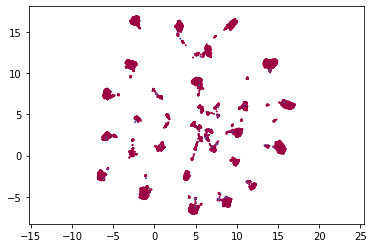

In [17]:
reducer = umap.UMAP(metric=heom, random_state=369)

umap_heom_embedding = reducer.fit_transform(X_data)

plt.clf()
plt.scatter(
    umap_heom_embedding[:, 0],
    umap_heom_embedding[:, 1],
    c=y_data.values.astype(int), s=1, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')

# UMAP-cosine

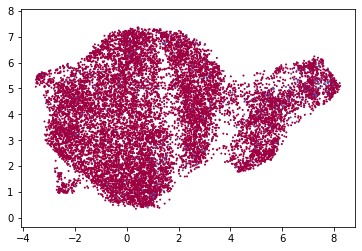

In [18]:
reducer = umap.UMAP(metric='cosine', random_state=369)

umap_cos_embedding = reducer.fit_transform(X_data_one_hot)

plt.clf()
plt.scatter(
    umap_cos_embedding[:, 0],
    umap_cos_embedding[:, 1],
    c=y_data.values.astype(int), s=1, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')

## Add cluster labels

In [117]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan, DBSCAN, MiniBatchKMeans
# 需要繼續調參增加類別，有兩個方向都是可以的，一個是繼續減少eps，另一個是增加min_samples
import hdbscan
# conda install -c conda-forge hdbscan

3
{0, 1, -1}


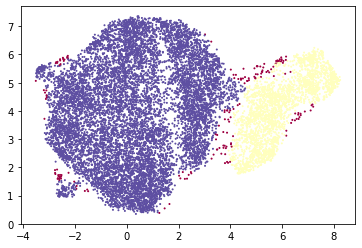

In [129]:
umap_cluster = hdbscan.HDBSCAN(
    min_samples=50,
    min_cluster_size=2,
    cluster_selection_epsilon=0.5
).fit(umap_cos_embedding)

plt.clf()
plt.scatter(umap_cos_embedding[:, 0],
            umap_cos_embedding[:, 1],
            c=umap_cluster.labels_,
            s=1,
            cmap='Spectral');
tidy_data['umap_label'] = umap_cluster.labels_
print(len(set(umap_cluster.labels_)))
print(set(umap_cluster.labels_))

In [130]:
tidy_data.to_csv('vital_sign_cluster.csv', index=False)